In [1]:
# Datafetch
# !wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE129nnn/GSE129788/suppl/GSE129788_RAW.tar
# !tar -xvf GSE129788_RAW.tar
# !gunzip *.gz

In [2]:
# !mkdir aging_brain
# !mv GSM37221* aging_brain
# !mv GSE129788_RAW.tar aging_brain/

In [3]:
sample_locations = !ls ./aging_brain/GSM*

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

samples = []

for sample_location in sample_locations:
    samples.append(sc.read(sample_location))

/localscratch/bbrener1/rusty_lumberjack/work/scanpy_environment/lib/python3.8/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [5]:
samples = [s.T for s in samples]

In [6]:
# Samples are already normalized so we will have to stack them unless I want to spend forever and a day downloading bullshit raw data

samples

[AnnData object with n_obs × n_vars = 1370 × 14699 ,
 AnnData object with n_obs × n_vars = 1666 × 14699 ,
 AnnData object with n_obs × n_vars = 1851 × 14699 ,
 AnnData object with n_obs × n_vars = 2279 × 14699 ,
 AnnData object with n_obs × n_vars = 1856 × 14699 ,
 AnnData object with n_obs × n_vars = 1839 × 14699 ,
 AnnData object with n_obs × n_vars = 2519 × 14699 ,
 AnnData object with n_obs × n_vars = 2648 × 14699 ,
 AnnData object with n_obs × n_vars = 1823 × 14699 ,
 AnnData object with n_obs × n_vars = 1489 × 14699 ,
 AnnData object with n_obs × n_vars = 3984 × 14699 ,
 AnnData object with n_obs × n_vars = 3803 × 14699 ,
 AnnData object with n_obs × n_vars = 2175 × 14699 ,
 AnnData object with n_obs × n_vars = 2242 × 14699 ,
 AnnData object with n_obs × n_vars = 2597 × 14699 ,
 AnnData object with n_obs × n_vars = 2928 × 14699 ]

In [7]:
combined = np.vstack([s.X for s in samples])
combined.shape

(37069, 14699)

In [8]:
stacked = sc.AnnData(combined)
stacked.var_names = samples[0].var_names
stacked

AnnData object with n_obs × n_vars = 37069 × 14699 

In [9]:
filter_result = sc.pp.filter_genes_dispersion(  # select highly-variable genes
    stacked.X, flavor='cell_ranger', n_top_genes=2000, log=True
)
filtered = stacked[:, filter_result.gene_subset]     # subset the genes


In [10]:
filtered

View of AnnData object with n_obs × n_vars = 37069 × 1999 

In [11]:
# We have to set up young vs old annotation:

young = np.zeros(37069,dtype=bool)
old = np.zeros(37069,dtype=bool)

young_samples = np.sum([s.shape[0] for s in samples[:8]])
young[:young_samples] = True

old_samples = np.sum([s.shape[0] for s in samples[8:]])
old[old_samples:] = True

In [12]:
young_samples+old_samples

37069

In [13]:
filtered.var_names
# samples[0].var_names

Index(['Sox17', 'Rgs20', 'Adhfe1', '3110035E14Rik', 'Cpa6', 'Prex2', 'Slco5a1',
       'Kcnb2', 'Gdap1', 'B3gat2',
       ...
       'Pnlip', 'Hspa12a', 'mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp6',
       'mt-Co3', 'mt-Nd4', 'mt-Cytb'],
      dtype='object', length=1999)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/localscratch/bbrener1/rusty_lumberjack/work/scanpy_environment/lib/python3.8/site-packages/numba/typed_passes.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../rusty_lumberjack/work/scanpy_environment/lib/python3.8/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/localscratch/bbrener1/rusty_lumberjack/work/scanpy_environment/lib/python3.8/site-packages/umap/nndescent.py:91: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numb

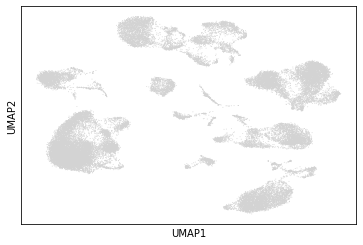

In [14]:
# Basic scanpy processing:

sc.pp.neighbors(filtered)
sc.tl.umap(filtered)
sc.pl.umap(filtered)

In [23]:
# import sys
# sys.path.append('/localscratch/bbrener1/rusty_forest_v3/src')
# # sys.path.append('../src')
# import tree_reader as tr 
# import lumberjack

# forest = lumberjack.fit(
#     filtered.X[young],
#     header=filtered.var_names,
#     trees=300,
#     braids=3,
#     ifs=700,
#     ofs=700,
#     ss=200,
#     depth=7,
#     leaves=100,
#     sfr=.5
# )

# forest.set_cache(True)
forest.backup("scanpy_cmp_aging_brain")


Saving forest
scanpy_cmp_aging_brain


In [16]:
import sys
sys.path.append('/localscratch/bbrener1/rusty_forest_v3/src')
# sys.path.append('../src')
import tree_reader as tr 
import lumberjack

forest = tr.Forest.reconstitute('scanpy_cmp_aging_brain')
forest.arguments

['/localscratch/bbrener1/rusty_forest_v3/target/release/rusty_lumberjack_v3',
 '-ic',
 '/tmp/tmpeavoiaxm/input.counts',
 '-oc',
 '/tmp/tmpeavoiaxm/output.counts',
 '-o',
 '/tmp/tmpeavoiaxm/tmp',
 '-auto',
 '-ifh',
 '/tmp/tmpeavoiaxm/tmp.ifh',
 '-ofh',
 '/tmp/tmpeavoiaxm/tmp.ofh',
 '-trees',
 '300',
 '-braids',
 '3',
 '-ifs',
 '700',
 '-ofs',
 '700',
 '-ss',
 '200',
 '-depth',
 '7',
 '-leaves',
 '100',
 '-sfr',
 '0.5']

In [ ]:
# forest.reset_split_clusters()
# forest.interpret_splits(depth=6,sub=.8,k=100,relatives=True,intercon=3,pca=100,mode='additive_mean',metric='cosine')

No split clusters
Relativistic distance (heh)
Additive mean reduction
Additive mean reduction
Distances ready
Subsampling connectivity: 0
Subsampling connectivity: 1
Subsampling connectivity: 2
Shuffling
Shuffle range: 110766257


In [20]:
forest.most_likely_tree(depth=6)

Clusters:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Prototype:[[0, 7], [3, 19, 20, 21, 23, 28], [4, 25, 26, 34, 35], [2, 6], [27], [36, 37], [5, 31, 32], [8, 9, 38], [1, 13, 14], [10], [15, 22, 24], [], [], [], [17, 18, 30, 33], [16], [], [11, 12], [39], [], [], [], [], [], [], [], [], [], [29], [], [], [], [], [], [], [], [], [], [], []]
Prototype length:40
Transitions:[[  0.  88.   0. ...   8.   0.   0.]
 [  0.   0.   5. ...   0.   0. 241.]
 [  0.  22.   0. ...   0.   0. 265.]
 ...
 [  0.   0.   0. ...   0.   1.  27.]
 [  0.   0.   0. ...   0.   0.  43.]
 [300.   0.   0. ...   0.   0.   0.]]
Transition mtx shape: (41, 41)
0
[[0, 7], [3, 19, 20, 21, 23, 28], [4, 25, 26, 34, 35], [2, 6], [27], [36, 37], [5, 31, 32], [8, 9, 38], [1, 13, 14], [10], [15, 22, 24], [], [], [], [17, 18, 30, 33], [16], [], [11, 12], [39], [], [], [], [], [], [], [], [], [], [29], [], [], [], [], [], [],

[0,
 [[7,
   [[8,
     [[1,
       [[3,
         [[2, [[4, [[27, []]]], [25, []], [26, []], [34, []], [35, []]]],
          [6, [[5, [[36, []], [37, []]]], [31, []], [32, []]]]]],
        [19, []],
        [20, []],
        [21, []],
        [23, []],
        [28, [[29, []]]]]],
      [13, []],
      [14,
       [[17, [[11, []], [12, []]]], [18, [[39, []]]], [30, []], [33, []]]]]],
    [9, [[10, [[15, [[16, []]]], [22, []], [24, []]]]]],
    [38, []]]]]]

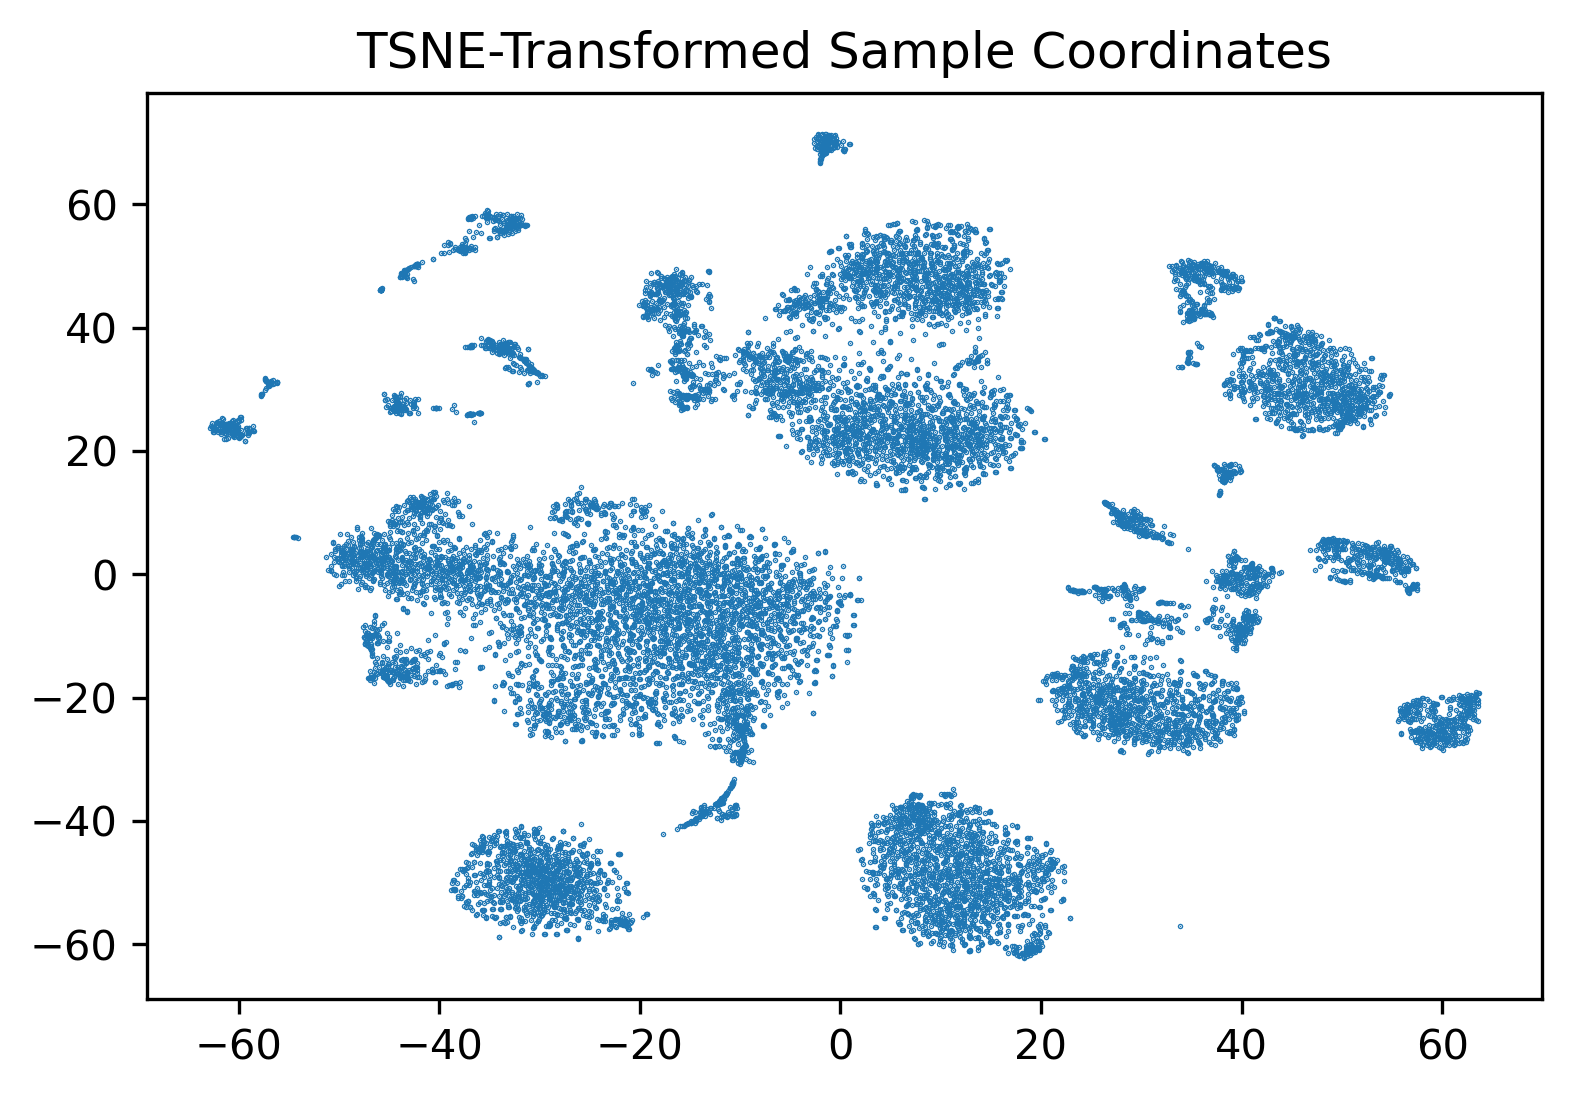

array([[  4.9502506, -44.442688 ],
       [ 11.693616 , -38.86479  ],
       [ 18.768702 , -60.859097 ],
       ...,
       [-43.848232 ,  48.357536 ],
       [-43.55364  ,  49.116028 ],
       [-43.194725 ,  48.112667 ]], dtype=float32)

In [21]:
forest.tsne()
# forest.html_tree_summary(n=10)

In [22]:
len(forest.split_clusters)

40